In [5]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.compose import ColumnTransformer 
from sklearn.preprocessing import OneHotEncoder, StandardScaler 
from sklearn.impute import KNNImputer 
from sklearn.model_selection import train_test_split 
from tensorflow.keras import layers, models 
from tensorflow.keras.metrics import BinaryAccuracy 
from tensorflow.keras.callbacks import EarlyStopping 
from tensorflow import keras 
import tensorflow as tf 
from sklearn.metrics import accuracy_score, recall_score, precision_score 
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout

In [2]:
pd.set_option('display.max_columns', None)
heart_data = pd.read_csv('/kaggle/input/heart-failure-prediction/heart.csv')
heart_data.head(10)

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/heart-failure-prediction/heart.csv'

<a id="4"></a>
<h2>Visualizing the Data</h2>

In [3]:
#displays stats about the data
heart_data.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


<h5>To note for late: RestingBP and Cholesterol both have minimum values of 0.0, this is impossible for a living person. This is most likely a place holder for missing values and will be treated as such later.</h5>

In [4]:
#display percent of dataset with heart disease
perc_dis = heart_data['HeartDisease'].sum() / len(heart_data)
print('Percent of patients in dataset with heart disease:', round(perc_dis, 4))

Percent of patients in dataset with heart disease: 0.5534


<h5>The dataset is balanced with 55%-45% split</h5>

In [5]:
#Creates lists of the columns based on the data type/how data should be visualized
#catagorical variables
cat_vars = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope', 'FastingBS']
#numeric variables
num_vars = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']
#label
label = 'HeartDisease'

In [6]:
#Creates functions for plotting variables 

#function for plotting catagoric variables as a bar chart
def display_barchart(data, var, label):
    #calculates the count of patients in each catagory vs heart disease
    grp = data.groupby([var, label])[var].count().unstack().reset_index()

    labels = list(grp.iloc[:, 0].values)
    no_dis = list(grp.iloc[:, 1].values) #no heart disease patients
    yes_dis = list(grp.iloc[:, 2].values) #heart disease patients

    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars
    
    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, no_dis, width, label='Healthy')
    rects2 = ax.bar(x + width/2, yes_dis, width, label='Heart Disease')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Number of Patients')
    ax.set_xlabel(var)
    ax.set_title('Heart Disease by ' + var)
    ax.set_xticks(x) # values
    ax.set_xticklabels(labels) # labels
    ax.legend()

    fig.tight_layout()
    plt.show()
    
    

#function for plotting numeric variables as a kde chart
def display_kdechart(data, var, label):
    plt.figure(figsize=(10, 6))
    sns.kdeplot(var, hue='HeartDisease', data=heart_data)
    plt.title('Heart Disease by ' + var + ' Distribution')
    plt.show()

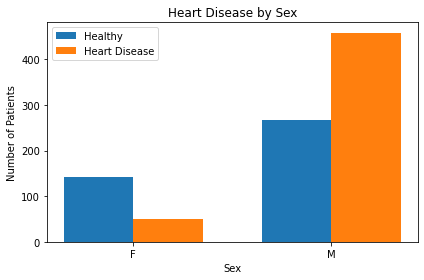

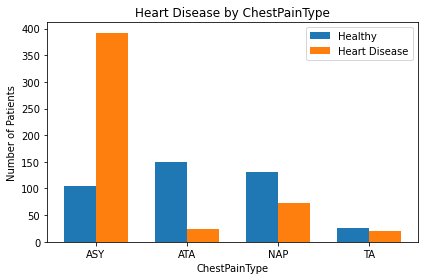

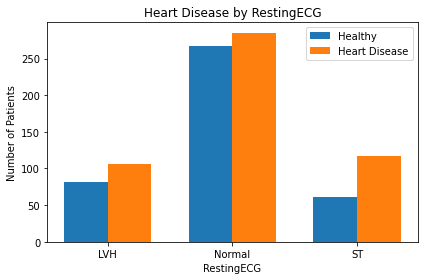

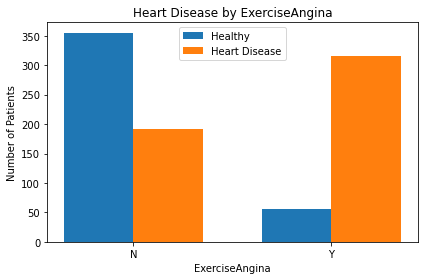

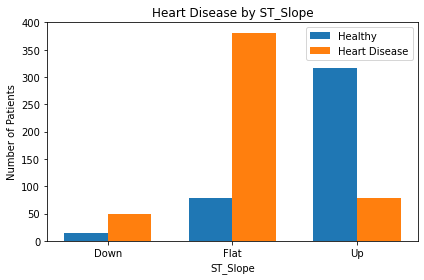

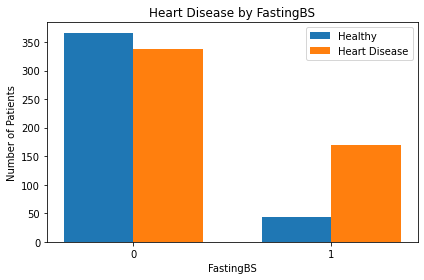

In [7]:
#plots catagoric valriables
for var in cat_vars:
    display_barchart(heart_data, var, label)

<h5>Findings for each catagoric variable:</h5>

<ul>
    <li><strong>Sex</strong> - males have quite a higher chance of getting heart disease than females.</li>
    <li><strong>ChestPainType</strong> - patients with ASY chest pain have a far higher chance of having heart disease than other types of chest pain. This is followed by TA chest pain (50% chance), NAP (under 50%) and ATA (low risk).</li>
    <li><strong>RestingECG</strong> - ST patients have a slight higher chance than others.</li>
    <li><strong>ExerciseAngina</strong> - patients with 'yes' have a far higher chance of heart disease.</li>
    <li><strong>ST_Slope</strong> - Flat and Down patients have far higher chance of heart disease than patients with Up.</li>
    <li><strong>FastingBS</strong> - patients with a high fasting blood sugar (> 120 mg/dl) have a far higher chance of heart disease.</li>
</ul>

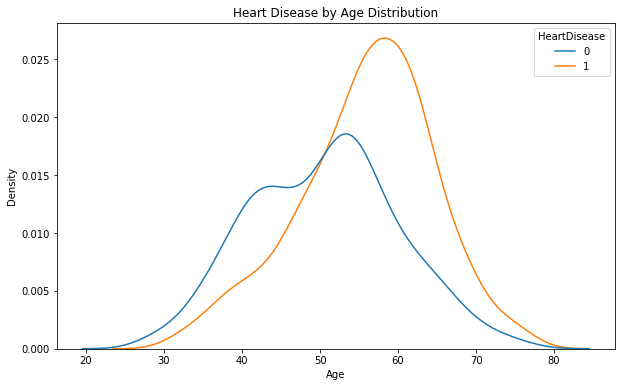

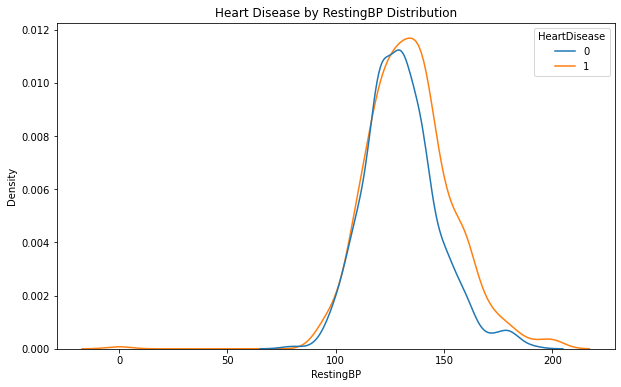

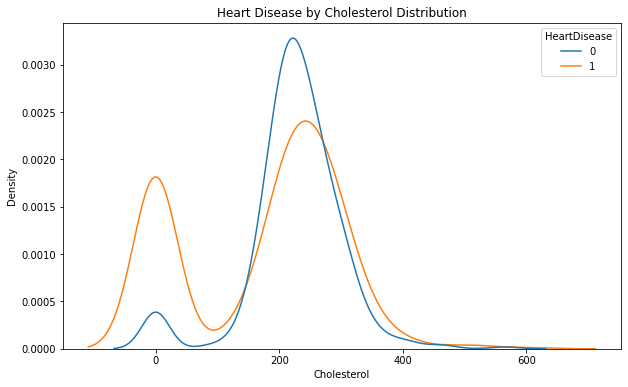

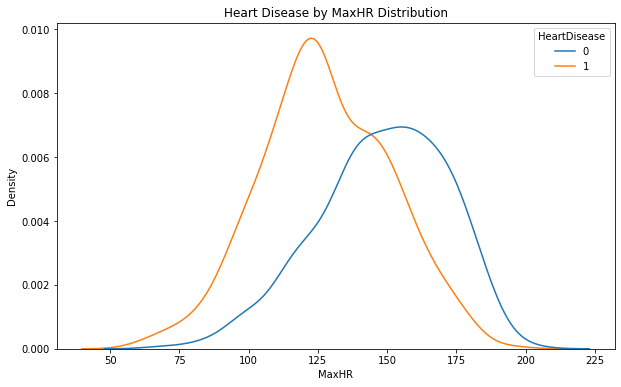

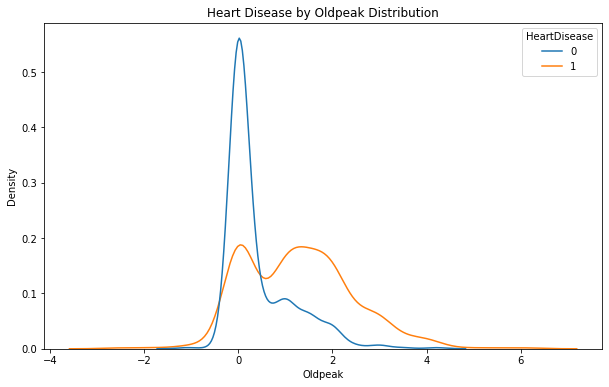

In [8]:
#plots numeric valriables
for var in num_vars:
    display_kdechart(heart_data, var, label)

<h5>Findings for each numeric variable:</h5>

<ul>
    <li><strong>Age</strong> - older patients have a higher risk of heart disease.</li>
    <li><strong>RestingBP</strong> - patients with a higher resting blood preasure have a slightly higher risk of heart disease</li>
    <li><strong>Cholesterol</strong> - based on the data it is difficult to determine if cholesteralis an indicator for heart disease. It is worth noting that for the 0 values (filler values), a vast majority of patients had heart disease.</li>
    <li><strong>MaxHR</strong> - patients with a lower maximum heart rate have a higher chance of heart disease.</li>
    <li><strong>OldPeak</strong> - patients with higher values are at risk for heart disease.</li>
</ul>

<a id="5"></a>
<h2>Data Preprocessing</h2>

<h5>Now that we better understand the data, the data can be processed to feed to the neural network. This will involve taking care of the 0 values for Cholesterol and RestingBP. Because Cholesterol was not a significant indicator of whether a patient has heart disease, it will be dropped. The 0 value for RestingBP will be filled with the average. After this, the catagoric variables need to be encoded and numeric variables scaled. Finally, the data set will be split into train, validation and test datasets.</h5>

In [9]:
#Missing Values (0)
#Takes care of the '0' values for RestingBP
bp_ix = heart_data[heart_data.RestingBP == 0].index[0]
bp_avg = heart_data.RestingBP.mean()
heart_data.loc[bp_ix, 'RestingBP'] =  bp_avg
#drops Cholesterol column
heart_data.drop('Cholesterol', axis=1, inplace=True)

#Encodes catagoric variables/Scales numeric variable
cat_cols = [1, 2, 5, 7, 9] #column index for catagoric variables
num_cols = [0, 3, 6, 8] #column index for numeric variables
#transforms each column based on its datatype -- columns not included are passed through
ct = ColumnTransformer([
    ('catagoric', OneHotEncoder(), cat_cols),
    ('numeric', StandardScaler(), num_cols)
    ], remainder='passthrough')
data_clean = ct.fit_transform(heart_data.values)
#displays a sample of the processed data
print('Cleaned Data:')
print(data_clean[0])

Cleaned Data:
[0.0 1.0 0.0 1.0 0.0 0.0 0.0 1.0 0.0 1.0 0.0 0.0 0.0 1.0
 -1.4331398004436657 0.4148614371130468 1.3829282169443904
 -0.832432393131704 0 0]


In [10]:
#Splits the data into train, test, validate
X, y = data_clean.T[:-1].T.astype('float32'), data_clean.T[-1].astype('float32')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.22, random_state=8)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=8)

#displays the amount of samples in each dataset
print('Samples in Train Set:', len(X_train))
print('Samples in Validation Set:', len(X_val))
print('Samples in Test Set:', len(X_test))

Samples in Train Set: 716
Samples in Validation Set: 101
Samples in Test Set: 101


<a id="6"></a>
<h2>Creating the Neural Network</h2>

In [11]:
nn = Sequential([
    Dense(64, activation='relu', input_shape=(19,)), 
    Dropout(0.3),
    
    Dense(128, activation='relu'),  
    Dropout(0.3),
    
    Dense(256, activation='relu'),  
    Dropout(0.3),
    
    Dense(512, activation='relu'),  
    Dropout(0.3),
    
    Dense(256, activation='relu'),  
    Dropout(0.3),
    
    Dense(128, activation='relu'),  
    Dropout(0.3),
    
    Dense(64, activation='relu'),  
    Dropout(0.3),
    
    Dense(32, activation='relu'),  
    Dropout(0.3),
    
    Dense(1, activation='sigmoid') 
])


nn.summary()


User settings:

   KMP_AFFINITY=granularity=fine,verbose,compact,1,0
   KMP_BLOCKTIME=0
   KMP_DUPLICATE_LIB_OK=True
   KMP_INIT_AT_FORK=FALSE
   KMP_SETTINGS=1
   KMP_WARNINGS=0

Effective settings:

   KMP_ABORT_DELAY=0
   KMP_ADAPTIVE_LOCK_PROPS='1,1024'
   KMP_ALIGN_ALLOC=64
   KMP_ALL_THREADPRIVATE=128
   KMP_ATOMIC_MODE=2
   KMP_BLOCKTIME=0
   KMP_CPUINFO_FILE: value is not defined
   KMP_DETERMINISTIC_REDUCTION=false
   KMP_DEVICE_THREAD_LIMIT=2147483647
   KMP_DISP_NUM_BUFFERS=7
   KMP_DUPLICATE_LIB_OK=true
   KMP_ENABLE_TASK_THROTTLING=true
   KMP_FORCE_REDUCTION: value is not defined
   KMP_FOREIGN_THREADS_THREADPRIVATE=true
   KMP_FORKJOIN_BARRIER='2,2'
   KMP_FORKJOIN_BARRIER_PATTERN='hyper,hyper'
   KMP_GTID_MODE=3
   KMP_HANDLE_SIGNALS=false
   KMP_HOT_TEAMS_MAX_LEVEL=1
   KMP_HOT_TEAMS_MODE=0
   KMP_INIT_AT_FORK=true
   KMP_LIBRARY=throughput
   KMP_LOCK_KIND=queuing
   KMP_MALLOC_POOL_INCR=1M
   KMP_NUM_LOCKS_IN_BLOCK=1
   KMP_PLAIN_BARRIER='2,2'
   KMP_PLAIN_BARRIER_P

Model: "heartdisease_predictor"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 19)]         0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 24)           480         input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 24)           0           dense[0][0]                      
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 24)           600         dropout[0][0]                    
_____________________________________________________________________________

<h3>Diagram of Neural Network Architecture</h3>

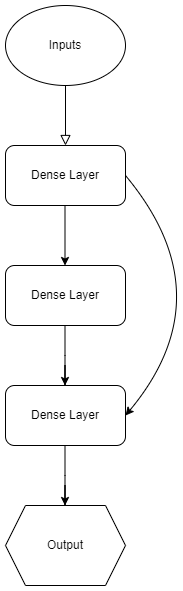

In [12]:
#compiles the model with Adam optimizer
nn.compile(optimizer=tf.optimizers.Adam(learning_rate=lr),
            loss='binary_crossentropy', metrics=[BinaryAccuracy()])
early_stopper = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

#Trains the neural network
nn.fit(X_train, y_train, epochs=1000, callbacks=[early_stopper], validation_data=(X_val, y_val))

2021-12-04 12:50:52.075391: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/1000
23/23 [==============================] - 1s 12ms/step - loss: 0.6883 - binary_accuracy: 0.5517 - val_loss: 0.5818 - val_binary_accuracy: 0.7921
Epoch 2/1000
23/23 [==============================] - 0s 3ms/step - loss: 0.5880 - binary_accuracy: 0.6941 - val_loss: 0.5060 - val_binary_accuracy: 0.8416
Epoch 3/1000
23/23 [==============================] - 0s 3ms/step - loss: 0.5030 - binary_accuracy: 0.7821 - val_loss: 0.4453 - val_binary_accuracy: 0.8317
Epoch 4/1000
23/23 [==============================] - 0s 3ms/step - loss: 0.4616 - binary_accuracy: 0.7961 - val_loss: 0.4116 - val_binary_accuracy: 0.8119
Epoch 5/1000
23/23 [==============================] - 0s 3ms/step - loss: 0.4270 - binary_accuracy: 0.8282 - val_loss: 0.3880 - val_binary_accuracy: 0.8218
Epoch 6/1000
23/23 [==============================] - 0s 3ms/step - loss: 0.4054 - binary_accuracy: 0.8212 - val_loss: 0.3755 - val_binary_accuracy: 0.8317
Epoch 7/1000
23/23 [==============================] - 0s 3ms/st

<h5>The best validation accuracy score is around 87%. This is not bad, next the model will be evaluated on the test set.</h5>

In [13]:
#Display the metrics of the neural network on the test set
test_preds = nn.predict(X_test)
test_preds = [round(float(i), 0) for i in test_preds]
test_acc = accuracy_score(y_test, test_preds)
test_rec = recall_score(y_test, test_preds)
test_pre = precision_score(y_test, test_preds)
print('Test Set Metrics')
print('Ensemble Model Accuracy:', test_acc)
print('Ensemble Model Recall:', test_rec)
print('Ensemble Model Precision:', test_pre)

Test Set Metrics
Ensemble Model Accuracy: 0.8712871287128713
Ensemble Model Recall: 0.9272727272727272
Ensemble Model Precision: 0.85


<h5>The current model accuracy is 87% on the test data and has a recall of around 93%. This recall is good but will allow some at risk patients to slip through the cracks. I will decrease the threshold and reevaluate.</h5>

In [14]:
test_preds = nn.predict(X_test)
test_preds = [1.0 if i > 0.09  else 0.0 for i in test_preds]
test_acc = accuracy_score(y_test, test_preds)
test_rec = recall_score(y_test, test_preds)
test_pre = precision_score(y_test, test_preds)
print('Test Set Metrics')
print('Ensemble Model Accuracy:', test_acc)
print('Ensemble Model Recall:', test_rec)
print('Ensemble Model Precision:', test_pre)

Test Set Metrics
Ensemble Model Accuracy: 0.7326732673267327
Ensemble Model Recall: 1.0
Ensemble Model Precision: 0.6707317073170732


<h5>With this new threshold, all at risk patients were identified. This decreased the accuracy to around 74% and will lead to around 30% of patients being falsley identified as at risk. These are acceptable numbers for the this problem.</h5>

<a id="7"></a>
<h2>Conclusions</h2>

<ul>
    <li><strong>There are many factors that can indicate a patient has a heart disease.</strong> In fact, almost all featires included in the dataset provided strong indicators of a patients risk for heart disease. These factors should be commonly monitored in patients, especially those patients who are elderly and male.</li>
    <li><strong>The final model correctly detects 100% of the patients who have heart disease.</strong> However, lowering the threshold to this level also lowered the accuracy to 74% and precision to 68%. 30% of the patients identified as at risk will not have heart disease, but this is an acceptable amount of false positives for this problem. This will be a great tool for medical professionals in identifying at risk patients.</li>
</ul>